In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from matplotlib import rcParams
from matplotlib import pyplot as plt
import matplotlib.patches as patches
pd.set_option('display.max_columns',None)

# Functions

In [98]:
def zspec_zphot(zspec,zphot,lims):
    inf,sup=lims
    bool_zspec = (zspec >= 0)&(zspec < 10)
    
    zspec = zspec[bool_zspec]
    zphot = zphot[bool_zspec]
    # Outliers
    delta_z      = np.abs(zphot - zspec)/(1+zspec)
    outliers     = delta_z > 0.15
    not_outliers = np.invert(outliers)
    # Catastrophic outliers 
    catastrophic        = np.abs(zphot - zspec)> 1
    not_catastrophic    = np.invert(catastrophic)
    # Percentuals 
    perc_central      = np.around(len(zphot[not_outliers])*100 / len(zspec),decimals=1)
    perc_outlier      = np.around((len(zphot[outliers]))*100   / len(zspec),decimals=1)
    perc_catastrophic = np.around(len(zphot[catastrophic])*100 / len(zspec),decimals=1)
    bias        = np.mean(delta_z)
    sigma       = np.std(delta_z)
    sigma_NMAD  = 1.4826*np.median(np.abs(delta_z))

    n68            = int(len(delta_z)*0.68)
    sort_abs_delta = np.sort(np.abs(delta_z))
    sigma_68       = sort_abs_delta[n68]
    eta            = (outliers.sum()*100)/len(outliers)

    print('|mean(Delta z)| =','%.4f'% np.abs(bias))
    print('std(Delta z)    =','%.4f'% sigma)
    print('sigma_NMAD      =','%.4f'% sigma_NMAD)
    print('sigma_68        =','%.4f'% sigma_68)
    print('eta             =','%.2f'% eta,'%')

    x = np.linspace(inf,sup,200)
    plt.figure(figsize=(8,8))

    plt.plot(zspec[not_outliers],zphot[not_outliers], '.',c='tab:blue',label='Central objects: '+str(not_outliers.sum())+'  ('+str(perc_central)+'%)')
    plt.plot(zspec[outliers], zphot[outliers], '.',c='tab:orange',label='Outliers: '+str(outliers.sum())+'  ('+str(perc_outlier)+'%)')
    plt.plot(zspec[catastrophic], zphot[catastrophic], '.',c='tab:red',label='Catastrophic outliers: '+str(catastrophic.sum())+'  ('+str(perc_catastrophic)+'%)')
    
    plt.plot(x,x,'-',c='tab:red',lw=4)
    plt.plot(x,x+1,'--',c='tab:red',lw=1)
    plt.plot(x,x-1,'--',c='tab:red',lw=1)
    plt.plot(x,1.15*x+0.15,'--',c='tab:red',lw=1)
    plt.plot(x,0.85*x-0.15,'--',c='tab:red',lw=1)
    plt.tick_params(top=True, right=True,direction='in')
    plt.xlabel('Z Spec')
    plt.ylabel('Photo Z')
    plt.xlim(inf-0.01,sup)
    plt.ylim(inf-0.01,sup)
    plt.legend()

def purezza(zspec,zphot,cluster):
    cluster_inf,cluster_sup = cluster
    existing_zspec   = (zspec >= 0)&(zspec < 10)
    
    spec_members     = (zspec>cluster_inf)&(zspec<cluster_sup) # Boolean on zspec
    levels_members   = np.percentile(zphot[spec_members],[16,50,84],axis=0)
    cluster_inf_phot = np.round(levels_members[0],3)
    cluster_sup_phot = np.round(levels_members[2],3)
    photo_members    = (zphot>cluster_inf_phot)&(zphot<cluster_sup_phot) # Boolean on zphot

    # How many galaxies have photometric redshift in the inverval 0.34<z_phot<0.47
    print('Galaxies having zphot in the cluster interval: ',photo_members.sum())
    
    # How many of these zphot cluster galaxies do have zspec? 
    zspec_match_zphotcluster = zspec[existing_zspec][photo_members] 

    # from these zspec_match_zphotcluster, how many zspec inside the 0.38<z_spec<0.41 inverval and how many outside? ---> QUANTIFY!!!
    zphot_with_zspec_inside  = (zspec_match_zphotcluster>cluster_inf) & (zspec_match_zphotcluster<cluster_sup)
    zphot_with_zspec_outside = (zspec_match_zphotcluster<cluster_inf) | (zspec_match_zphotcluster>cluster_sup)

    print('Purity: Zphot with Zspec inside the cluster interval',zphot_with_zspec_inside.sum(),   '   (%.2f)'%(zphot_with_zspec_inside.sum()*100/len(zspec_match_zphotcluster)))
    print('Impurity: Zphot with Zspec otside the cluster interval',zphot_with_zspec_outside.sum(), '   (%.2f)'%(zphot_with_zspec_outside.sum()*100/len(zspec_match_zphotcluster)))
    
header_lp        = ['IDENT', 'Z_BEST', 'Z_BEST68_LOW', 'Z_BEST68_HIGH', 'Z_ML', 'CHI_BEST', 'MOD_BEST', 'EXTLAW_BEST', 'EBV_BEST', 'PDZ_BEST', 'SCALE_BEST', 'DIST_MOD_BEST', 'NBAND_USED', 'Z_SEC', 'CHI_SEC', 'MOD_SEC', 'Z_QSO', 'CHI_QSO', 'MOD_QSO', 'MOD_STAR', 'CHI_STAR', 'MAG_OBS_U', 'MAG_OBS_G', 'MAG_OBS_R', 'MAG_OBS_I', 'MAG_OBS_Y', 'MAG_OBS_J', 'MAG_OBS_K', 'ERR_MAG_OBS_U', 'ERR_MAG_OBS_G', 'ERR_MAG_OBS_R', 'ERR_MAG_OBS_I', 'ERR_MAG_OBS_Y', 'ERR_MAG_OBS_J', 'ERR_MAG_OBS_K', 'MAG_MOD_U', 'MAG_MOD_G', 'MAG_MOD_R', 'MAG_MOD_I', 'MAG_MOD_Y', 'MAG_MOD_J', 'MAG_MOD_K','CONTEXT', 'ZSPEC']
macs0416 = (0.382,0.41)


# match7_ap1_1
## using match7 catalog ---> only objects that initially were in the 7 bands

In [2]:
# GAME CATALOG WITH ONLY THE MATCHED OBJECTS:
match7           = pd.read_csv("/Users/nestrada/Documents/Game/match_catalogues/match_m0416_ugriyjk_header.cat",sep='\s+',escapechar='#')

# GAME CATALOG WITH ONLY THE ZSPEC OBJECTS:
spectro4u        = pd.read_csv("/users/nestrada/Documents/Game/adding/spectro4u_plus.cat",sep='\s+',escapechar='#')

# LEPHARE OUTPUT + COLUMNS
match7_lp_1      = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_1/match7_ap1_1.out",sep='\s+',skiprows=62,header=None)
header_lp        = ['IDENT', 'Z_BEST', 'Z_BEST68_LOW', 'Z_BEST68_HIGH', 'Z_ML', 'CHI_BEST', 'MOD_BEST', 'EXTLAW_BEST', 'EBV_BEST', 'PDZ_BEST', 'SCALE_BEST', 'DIST_MOD_BEST', 'NBAND_USED', 'Z_SEC', 'CHI_SEC', 'MOD_SEC', 'Z_QSO', 'CHI_QSO', 'MOD_QSO', 'MOD_STAR', 'CHI_STAR', 'MAG_OBS_U', 'MAG_OBS_G', 'MAG_OBS_R', 'MAG_OBS_I', 'MAG_OBS_Y', 'MAG_OBS_J', 'MAG_OBS_K', 'ERR_MAG_OBS_U', 'ERR_MAG_OBS_G', 'ERR_MAG_OBS_R', 'ERR_MAG_OBS_I', 'ERR_MAG_OBS_Y', 'ERR_MAG_OBS_J', 'ERR_MAG_OBS_K', 'MAG_MOD_U', 'MAG_MOD_G', 'MAG_MOD_R', 'MAG_MOD_I', 'MAG_MOD_Y', 'MAG_MOD_J', 'MAG_MOD_K','CONTEXT', 'ZSPEC']
match7_lp_1.columns = header_lp

# Selecting redshift interval around cluster

In [5]:
zphot_cluster  = (match7_lp_1['Z_BEST'] > 0.342) & (match7_lp_1['Z_BEST'] < 0.473)
z_spec_cluster = (spectro4u['z_clash'] > 0.382) & (spectro4u['z_clash'] < 0.41)
print(zphot_cluster.sum())
print(z_spec_cluster.sum())

11185
967


# Plotting Ra-Dec 

Text(0, 0.5, 'DEC [deg]')

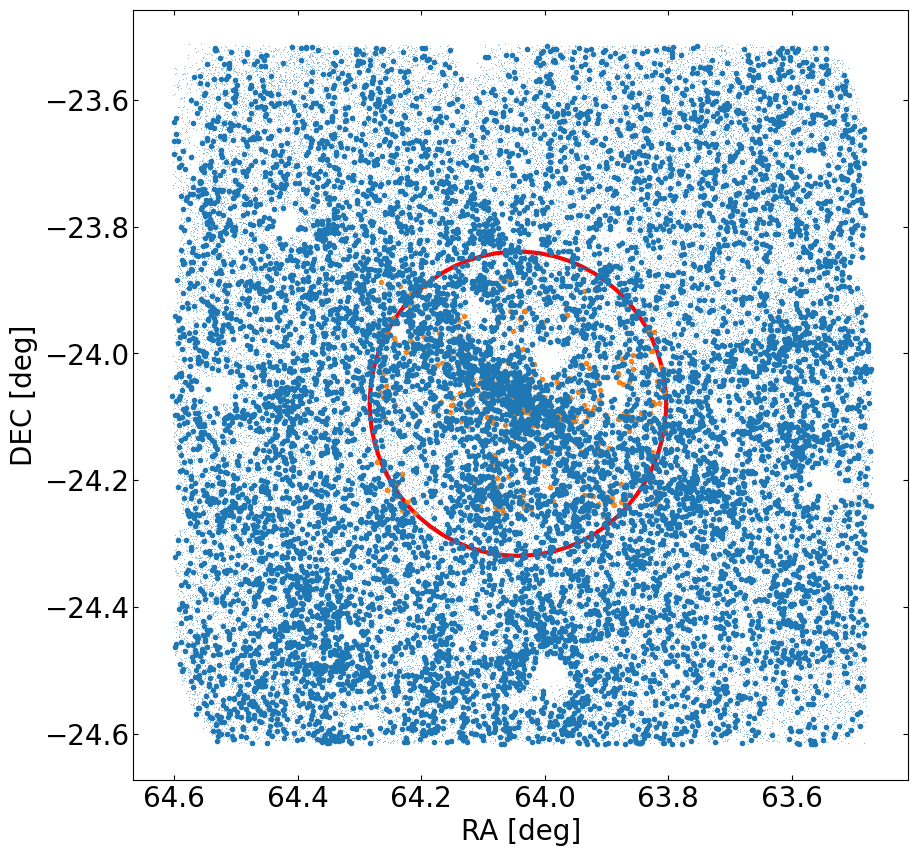

In [6]:
plt.style.use('default')
plt.figure(figsize=(10,10))
plt.rcParams["font.size"] = 20

plt.plot(spectro4u['RA_r'][z_spec_cluster],spectro4u['DEC_r'][z_spec_cluster],'.',alpha=0.9,c='tab:orange',label='0.382 < $z_{spec}$ < 0.41')
plt.plot(match7['RA_r'],match7['DEC_r'], ',',c='tab:blue',label='',alpha=0.5)
plt.plot(match7['RA_r'][zphot_cluster],match7['DEC_r'][zphot_cluster], '.',c='tab:blue',label='0.342 < $z_{phot}$ < 0.473')

fig = plt.gcf()
ax  = fig.gca()
ax.add_artist(patches.Circle((spectro4u['RA_r'].mean(), spectro4u['DEC_r'].mean()), 0.24,fill=False,color='r',lw=3))    
plt.gca().invert_xaxis()
plt.tick_params(top=True, right=True,direction='in')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')


# Z-phot histogram

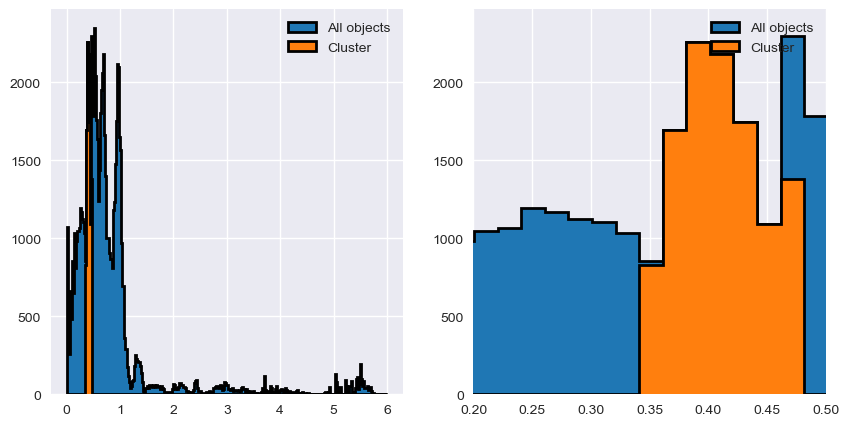

In [7]:
bins = np.linspace(0,6,300)
plt.figure(figsize=(10,5))
plt.style.use('seaborn')
plt.subplot(121)
plt.hist(match7_lp_1['Z_BEST'], bins=bins, histtype='step', linewidth=2, facecolor='tab:blue', edgecolor='k',fill=True,label='All objects')
plt.hist(match7_lp_1['Z_BEST'][zphot_cluster], bins=bins, histtype='step', linewidth=2, facecolor='tab:orange', edgecolor='k',fill=True,label='Cluster')

#plt.xlim(0.2,0.5)
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.rcParams["font.size"] = 20
plt.tick_params(top=True, right=True,direction='in')
plt.subplot(122)
plt.hist(match7_lp_1['Z_BEST'], bins=bins, histtype='step', linewidth=2, facecolor='tab:blue', edgecolor='k',fill=True,label='All objects')
plt.hist(match7_lp_1['Z_BEST'][zphot_cluster], bins=bins, histtype='step', linewidth=2, facecolor='tab:orange', edgecolor='k',fill=True,label='Cluster')

plt.xlim(0.2,0.5)
plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.rcParams["font.size"] = 20
plt.tick_params(top=True, right=True,direction='in')



In [8]:
zspec_match7 = spectro4u[spectro4u['ID_r'].isin(match7_lp_1['IDENT'])]
#zspec_match7.reset_index(drop=True, inplace=True)
zspec_match7.set_index('ID_r')
display(zspec_match7.describe())
#display(zspec_match7.sample(5))

match7_zspec = match7_lp_1[match7_lp_1['IDENT'].isin(zspec_match7['ID_r'])]
#match7_zspec.reset_index(drop=True, inplace=True)
match7_zspec.set_index('IDENT')
display(match7_zspec.describe())


result = pd.concat([zspec_match7, match7_zspec], axis=0, join="inner")
#display(result.describe())
display(result.sample(5))

"""
# Outliers
out_ap1_1     = np.abs(match7_lp_1['Z_BEST'][game_zspec] - match7_lp_1['ZSPEC'][game_zspec])/(1+match7_lp_1['ZSPEC'][game_zspec]) > 0.15
not_out_ap1_1 = np.invert(out_ap1_1)
print(match7_lp_1.shape,out_ap1_1.shape)
# Catastrophic outliers 
co_ap1_1     = np.abs(match7_lp_1['Z_BEST'][game_zspec] - match7_lp_1['ZSPEC'][game_zspec])> 1
not_co_ap1_1 = np.invert(co_ap1_1)"""

,ID_clash,RA_clash,DEC_clash,z_clash,ID_u,RA_u,DEC_u,MAG_AUTO_u,MAGERR_AUTO_u,KRON_RADIUS_u,...,CLASS_STAR_k,FWHM_IMAGE_k,A_IMAGE_k,B_IMAGE_k,THETA_IMAGE_k,MAG_PSF_k,MAGERR_PSF_k,MAG_MODEL_k,MAGERR_MODEL_k,SPREAD_MODEL_k
count,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,...,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000,3592.000000
mean,79322.385579,64.042804,-24.079730,0.474920,118653.148942,64.042826,-24.079734,24.829147,1.060340,3.770679,...,0.111065,7.337575,3.037807,2.270141,0.962094,21.351706,0.172152,20.756180,0.204382,0.012286
std,37428.245081,0.126650,0.105074,0.338904,25854.517348,0.126654,0.105081,7.048454,9.158247,0.592832,...,0.205393,4.869747,2.039289,1.089175,50.640628,3.219059,3.690439,1.515436,0.416140,0.007177
min,-284.000000,63.802059,-24.263133,0.000000,74553.000000,63.802064,-24.263147,15.991800,0.000200,0.000000,...,0.000000,0.000000,0.736000,0.359000,-89.930000,16.338400,0.000200,15.275100,0.000800,-0.055810
25%,47774.500000,63.944878,-24.168475,0.335275,97243.250000,63.944912,-24.168498,23.342550,0.050500,3.500000,...,0.010000,5.390000,2.078750,1.562000,-42.795000,20.210400,0.006900,19.672050,0.040700,0.007913
50%,79273.000000,64.044397,-24.080015,0.403500,118303.500000,64.044421,-24.080074,24.194700,0.096050,3.530000,...,0.029000,6.590000,2.729000,2.148500,1.345000,21.470200,0.022150,20.963200,0.103000,0.012275
75%,107644.000000,64.138171,-24.001219,0.545950,137292.750000,64.138180,-24.001227,25.011450,0.185325,3.960000,...,0.082000,8.370000,3.591750,2.743250,43.420000,22.408625,0.052325,21.957000,0.231600,0.017180
max,164865.000000,64.275253,-23.879591,4.149400,236837.000000,64.275294,-23.879615,99.000000,99.000000,7.100000,...,0.990000,169.560000,67.284000,12.161000,89.960000,99.000000,99.000000,24.280500,8.006100,0.037402


,IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_ML,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,PDZ_BEST,...,ERR_MAG_OBS_K,MAG_MOD_U,MAG_MOD_G,MAG_MOD_R,MAG_MOD_I,MAG_MOD_Y,MAG_MOD_J,MAG_MOD_K,CONTEXT,ZSPEC
count,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,3.590000e+03,3590.000000,3590.0,3590.0,3590.00000,...,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,3590.000000,3590.0,3590.0
mean,118650.329526,0.485699,0.472536,0.498122,-14.152296,4.411079e+03,15.842061,0.0,0.0,98.78207,...,0.038352,34.669002,25.961296,23.101539,22.671726,22.250235,21.998709,21.646717,127.0,-99.0
std,25861.279273,0.480288,0.474445,0.485113,35.240852,7.344888e+04,6.842442,0.0,0.0,5.63757,...,0.038229,98.103790,41.339576,1.160539,1.218911,1.302794,1.355426,1.432660,0.0,0.0
min,74553.000000,0.000000,0.000000,0.000000,-99.000000,7.201580e-01,1.000000,0.0,0.0,27.91800,...,0.000000,10.789000,9.385000,8.798000,8.606000,8.292000,8.230000,8.380000,127.0,-99.0
25%,97235.750000,0.363500,0.351025,0.365225,0.280000,2.032845e+01,11.000000,0.0,0.0,100.00000,...,0.008000,24.414000,23.683000,22.440250,21.949000,21.420000,21.103250,20.621000,127.0,-99.0
50%,118293.000000,0.410300,0.399350,0.422450,0.399000,6.745980e+01,18.000000,0.0,0.0,100.00000,...,0.025000,25.070500,24.363000,23.249000,22.842000,22.444500,22.207500,21.869000,127.0,-99.0
75%,137302.250000,0.496400,0.479900,0.512375,0.479975,4.405707e+02,21.000000,0.0,0.0,100.00000,...,0.058000,25.712000,25.003500,23.935000,23.578000,23.247750,23.054750,22.802500,127.0,-99.0
max,236837.000000,5.619500,5.599900,5.605500,5.405400,3.748630e+06,31.000000,0.0,0.0,116.55900,...,0.223000,1040.135000,1037.941000,27.041000,25.594000,25.486000,25.217000,24.397000,127.0,-99.0


""
2312
33613
36054
45799
49511


"\n# Outliers\nout_ap1_1     = np.abs(match7_lp_1['Z_BEST'][game_zspec] - match7_lp_1['ZSPEC'][game_zspec])/(1+match7_lp_1['ZSPEC'][game_zspec]) > 0.15\nnot_out_ap1_1 = np.invert(out_ap1_1)\nprint(match7_lp_1.shape,out_ap1_1.shape)\n# Catastrophic outliers \nco_ap1_1     = np.abs(match7_lp_1['Z_BEST'][game_zspec] - match7_lp_1['ZSPEC'][game_zspec])> 1\nnot_co_ap1_1 = np.invert(co_ap1_1)"

In [10]:
"""x = np.linspace(0,5,200)
plt.figure(figsize=(10,10))

plt.plot(zspec_match7['z_clash'],match7_zspec['Z_BEST'], '.',c='tab:blue',label='Central objects: '+str(match7_zspec.sum()))
#plt.plot(spectro4u['z_clash'][boolxxx][out_ap1_1], match7_lp_1['Z_BEST'][boolyyy][out_ap1_1], '.',c='tab:orange',label='Outliers: '+str(out_ap1_1.sum()-co_ap1_1.sum()))
#plt.plot(spectro4u['z_clash'][boolxxx][co_ap1_1], match7_lp_1['Z_BEST'][boolyyy][co_ap1_1], '.',c='tab:red',label='Catastrophic outliers: '+str(co_ap1_1.sum()))

plt.plot(x,x,'-',c='tab:red',lw=4)
plt.plot(x,x+1,'--',c='tab:red',lw=1)
plt.plot(x,x-1,'--',c='tab:red',lw=1)
plt.plot(x,1.15*x+0.15,'--',c='tab:red',lw=1)
plt.plot(x,0.85*x-0.15,'--',c='tab:red',lw=1)
plt.tick_params(top=True, right=True,direction='in')
plt.xlabel('Z Spec')
plt.ylabel('Photo Z')
#plt.xlim(-0.1,5)
#plt.ylim(-0.1,6)
plt.legend()
#plt.title('Wooooorking here!')"""

"x = np.linspace(0,5,200)\nplt.figure(figsize=(10,10))\n\nplt.plot(zspec_match7['z_clash'],match7_zspec['Z_BEST'], '.',c='tab:blue',label='Central objects: '+str(match7_zspec.sum()))\n#plt.plot(spectro4u['z_clash'][boolxxx][out_ap1_1], match7_lp_1['Z_BEST'][boolyyy][out_ap1_1], '.',c='tab:orange',label='Outliers: '+str(out_ap1_1.sum()-co_ap1_1.sum()))\n#plt.plot(spectro4u['z_clash'][boolxxx][co_ap1_1], match7_lp_1['Z_BEST'][boolyyy][co_ap1_1], '.',c='tab:red',label='Catastrophic outliers: '+str(co_ap1_1.sum()))\n\nplt.plot(x,x,'-',c='tab:red',lw=4)\nplt.plot(x,x+1,'--',c='tab:red',lw=1)\nplt.plot(x,x-1,'--',c='tab:red',lw=1)\nplt.plot(x,1.15*x+0.15,'--',c='tab:red',lw=1)\nplt.plot(x,0.85*x-0.15,'--',c='tab:red',lw=1)\nplt.tick_params(top=True, right=True,direction='in')\nplt.xlabel('Z Spec')\nplt.ylabel('Photo Z')\n#plt.xlim(-0.1,5)\n#plt.ylim(-0.1,6)\nplt.legend()\n#plt.title('Wooooorking here!')"

# NOW A ROW OF 4 TESTS WITH A DIFFERENT CATALOG:



# LePhare + GAME catalog ---> match7 + spectro4u

In [107]:
game             = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/GAME_0416.cat",sep=',',escapechar='#')
gamelp_input_ap1 = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/GAME_0416_lephare_AP1.cat",escapechar='#')

# game_nozspec   = gamelp_input_ap1['z_clash'].isnull() 
# game_zspec     = ~gamelp_input_ap1['z_clash'].isnull() 
game_nozspec   = gamelp_input_ap1['z_clash'] == -99
game_zspec     = gamelp_input_ap1['z_clash'] != -99
nsflag_zero    = game['NSFLAG_r']==0
print(game_zspec.sum())

4444


# match7_ap1_2

## CONTEXT -1 ZFIX YES, AUTO_ADAPT YES

In [108]:
gamelp_out_ap1_2 = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2/match7_ap1_2.out",sep='\s+',skiprows=82,header=None)
gamelp_out_ap1_2.columns = header_lp

|mean(Delta z)| = 0.0000
std(Delta z)    = 0.0000
sigma_NMAD      = 0.0000
sigma_68        = 0.0000
eta             = 0.00 %
Galaxies having zphot in the cluster interval:  1018
Purity: Zphot with Zspec inside the cluster interval 641    (100.00)
Impurity: Zphot with Zspec otside the cluster interval 0    (0.00)


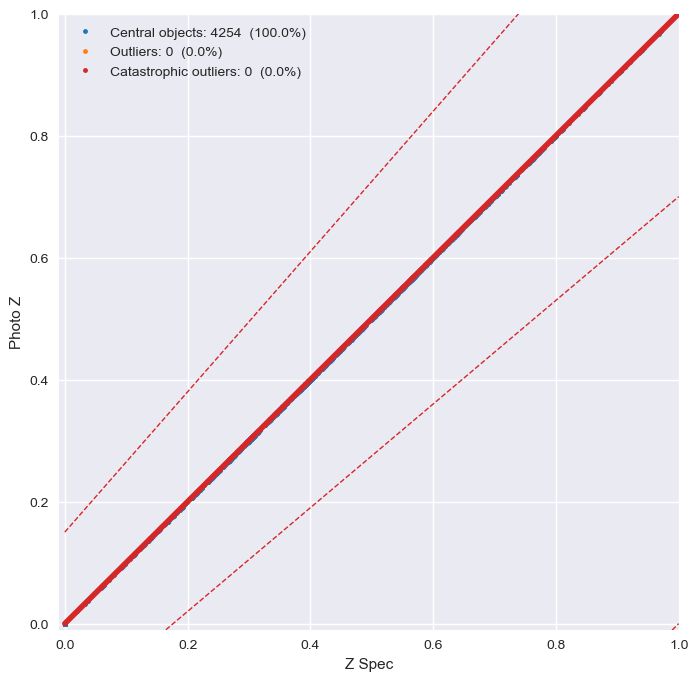

In [111]:
zspec_zphot(gamelp_out_ap1_2['ZSPEC'][nsflag_zero],gamelp_out_ap1_2['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2['ZSPEC'][nsflag_zero],gamelp_out_ap1_2['Z_BEST'][nsflag_zero],macs0416)

In [87]:
wrong_ap1_2 = gamelp_out_ap1_2['Z_BEST']==-99
print("Number of objects with zphot = -99", wrong_ap1_2.sum())

Number of objects with zphot = -99 0


# match7_ap1_2A

## CONTEXT 0, ZFIX YES, AUTO_ADAPT YES

In [88]:
gamelp_out_ap1_2A = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2A/match7_ap1_2A.out",sep='\s+',skiprows=82,header=None)
gamelp_out_ap1_2A.columns = header_lp

|mean(Delta z)| = 0.0000
std(Delta z)    = 0.0000
sigma_NMAD      = 0.0000
sigma_68        = 0.0000
eta             = 0.00 %
Galaxies having zphot in the cluster interval:  1001
Purity: Zphot with Zspec inside the cluster interval 641    (100.00)
Impurity: Zphot with Zspec otside the cluster interval 0    (0.00)


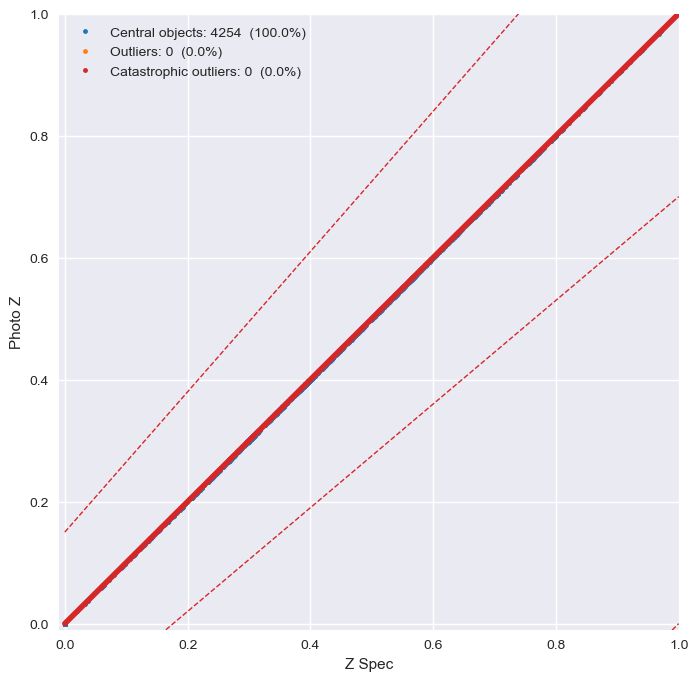

In [112]:
zspec_zphot(gamelp_out_ap1_2A['ZSPEC'][nsflag_zero],gamelp_out_ap1_2A['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2A['ZSPEC'][nsflag_zero],gamelp_out_ap1_2A['Z_BEST'][nsflag_zero],macs0416)

# match7_ap1_2B
## CONTEXT 0, ZFIX NO, AUTO_ADAPT YES

In [92]:
gamelp_out_ap1_2B = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2B/match7_ap1_2B.out",sep='\s+',skiprows=82,header=None)
gamelp_out_ap1_2B.columns = header_lp

|mean(Delta z)| = 0.1082
std(Delta z)    = 0.3638
sigma_NMAD      = 0.0524
sigma_68        = 0.0574
eta             = 10.74 %
Galaxies having zphot in the cluster interval:  6869
Purity: Zphot with Zspec inside the cluster interval 638    (44.68)
Impurity: Zphot with Zspec otside the cluster interval 788    (55.18)


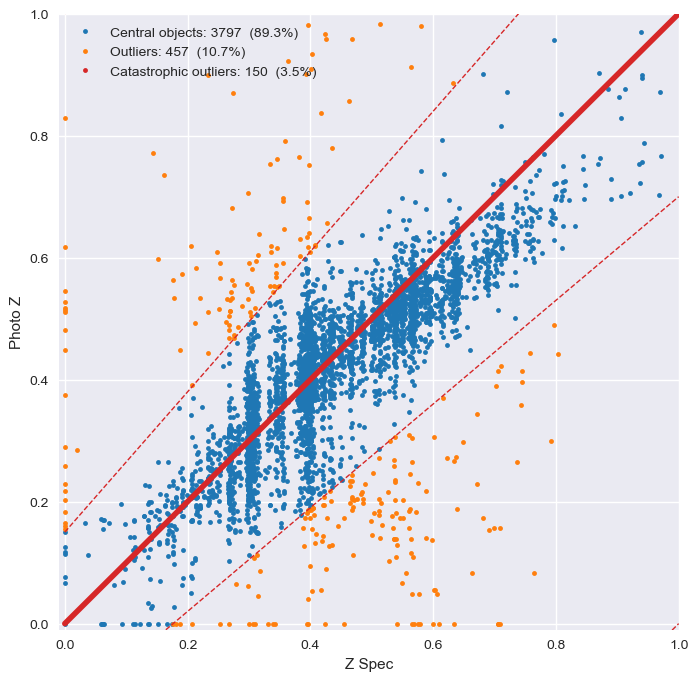

In [113]:
zspec_zphot(gamelp_out_ap1_2B['ZSPEC'][nsflag_zero],gamelp_out_ap1_2B['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2B['ZSPEC'][nsflag_zero],gamelp_out_ap1_2B['Z_BEST'][nsflag_zero],macs0416)

# match7_ap1_2C
##  CONTEXT 0, ZFIX NO, AUTO_ADAPT YES, ERROR_ADAPT YES

### BIG FAILURE!

In [115]:
gamelp_out_ap1_2C = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2C/match7_ap1_2C.out",sep='\s+',skiprows=82,header=None)
gamelp_out_ap1_2C.columns = header_lp

|mean(Delta z)| = 68.5841
std(Delta z)    = 10.0492
sigma_NMAD      = 104.7464
sigma_68        = 71.4935
eta             = 100.00 %
Galaxies having zphot in the cluster interval:  0
Purity: Zphot with Zspec inside the cluster interval 0    (nan)
Impurity: Zphot with Zspec otside the cluster interval 0    (nan)


<ipython-input-98-7a45117718e5>:72: RuntimeWarning: invalid value encountered in long_scalars
  print('Purity: Zphot with Zspec inside the cluster interval',zphot_with_zspec_inside.sum(),   '   (%.2f)'%(zphot_with_zspec_inside.sum()*100/len(zspec_match_zphotcluster)))
<ipython-input-98-7a45117718e5>:73: RuntimeWarning: invalid value encountered in long_scalars
  print('Impurity: Zphot with Zspec otside the cluster interval',zphot_with_zspec_outside.sum(), '   (%.2f)'%(zphot_with_zspec_outside.sum()*100/len(zspec_match_zphotcluster)))


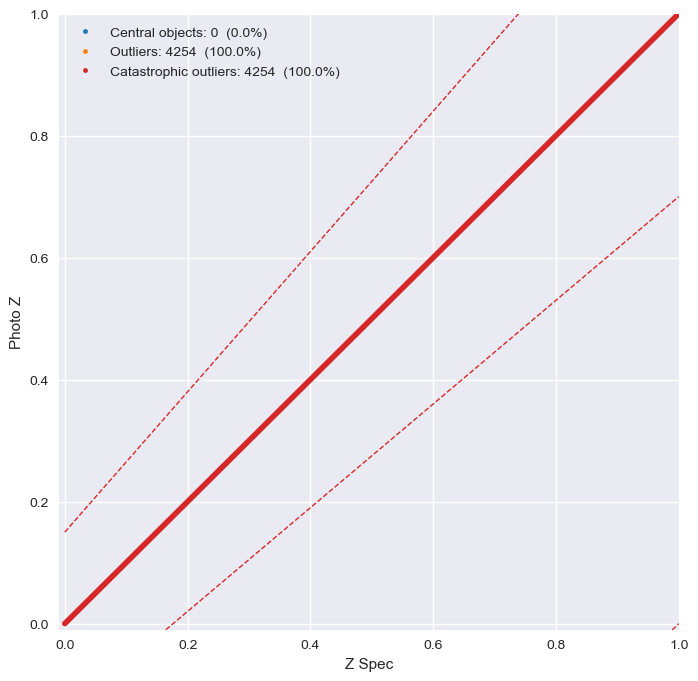

In [116]:
zspec_zphot(gamelp_out_ap1_2C['ZSPEC'][nsflag_zero],gamelp_out_ap1_2C['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2C['ZSPEC'][nsflag_zero],gamelp_out_ap1_2C['Z_BEST'][nsflag_zero],macs0416)

In [117]:
print('gamelp_out_ap1_2C')
display(gamelp_out_ap1_2C.sample(10))


gamelp_out_ap1_2C


,IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_ML,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,PDZ_BEST,SCALE_BEST,DIST_MOD_BEST,NBAND_USED,Z_SEC,CHI_SEC,MOD_SEC,Z_QSO,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,MAG_OBS_U,MAG_OBS_G,MAG_OBS_R,MAG_OBS_I,MAG_OBS_Y,MAG_OBS_J,MAG_OBS_K,ERR_MAG_OBS_U,ERR_MAG_OBS_G,ERR_MAG_OBS_R,ERR_MAG_OBS_I,ERR_MAG_OBS_Y,ERR_MAG_OBS_J,ERR_MAG_OBS_K,MAG_MOD_U,MAG_MOD_G,MAG_MOD_R,MAG_MOD_I,MAG_MOD_Y,MAG_MOD_J,MAG_MOD_K,CONTEXT,ZSPEC
19229,19229,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,25.067,24.862,24.417,24.296,23.503,23.270,22.862,0.082,0.016,0.025,0.052,0.037,0.038,0.065,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,-99.0000
61105,61105,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,24.059,23.302,21.904,21.426,20.922,20.638,19.939,0.039,0.005,0.003,0.004,0.004,0.003,0.004,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,-99.0000
36487,36487,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,99.000,25.323,23.609,23.045,22.633,22.327,21.698,99.000,0.023,0.011,0.015,0.019,0.018,0.025,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,0.4010
22655,22655,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,27.186,25.595,24.301,23.832,23.424,23.322,22.749,0.691,0.033,0.024,0.035,0.040,0.045,0.065,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,-99.0000
77317,77317,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,19.678,18.791,18.286,18.148,18.218,18.285,18.744,0.001,0.000,0.000,0.000,0.000,0.000,0.002,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,-99.0000
26596,26596,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,24.358,23.919,23.019,22.501,22.204,21.974,21.392,0.043,0.007,0.007,0.010,0.013,0.013,0.018,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,-99.0000
25918,25918,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,25.598,24.901,24.011,23.822,23.810,23.618,23.340,0.119,0.015,0.015,0.030,0.050,0.053,0.102,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,0.2921
8679,8679,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,24.612,24.271,23.360,22.905,22.643,22.663,22.006,0.045,0.009,0.009,0.014,0.019,0.024,0.033,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,-99.0000
57525,57525,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,25.674,25.690,25.074,24.652,23.993,23.359,22.290,0.145,0.034,0.045,0.071,0.066,0.046,0.042,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,-99.0000
53291,53291,-99.0,-99.0,-99.0,-99.0,1.000000e+10,-999,0,-99.0,0.0,-99.0,-99.0,7,-99.0,1.000000e+09,-999,-99.0,1.000000e+10,-999,-999,1.000000e+10,26.448,24.791,23.223,22.688,22.247,21.960,21.370,0.237,0.014,0.008,0.011,0.012,0.012,0.017,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,127.0,-99.0000


# match7_ap1_2D
## CONTEXT 0, ZFIX NO, AUTO_ADAPT NO

In [118]:
gamelp_out_ap1_2D = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2D/match7_ap1_2D.out",sep='\s+',skiprows=62,header=None)
gamelp_out_ap1_2D.columns = header_lp

|mean(Delta z)| = 0.1127
std(Delta z)    = 0.3602
sigma_NMAD      = 0.0618
sigma_68        = 0.0651
eta             = 10.01 %
Galaxies having zphot in the cluster interval:  7780
Purity: Zphot with Zspec inside the cluster interval 637    (41.61)
Impurity: Zphot with Zspec otside the cluster interval 893    (58.33)


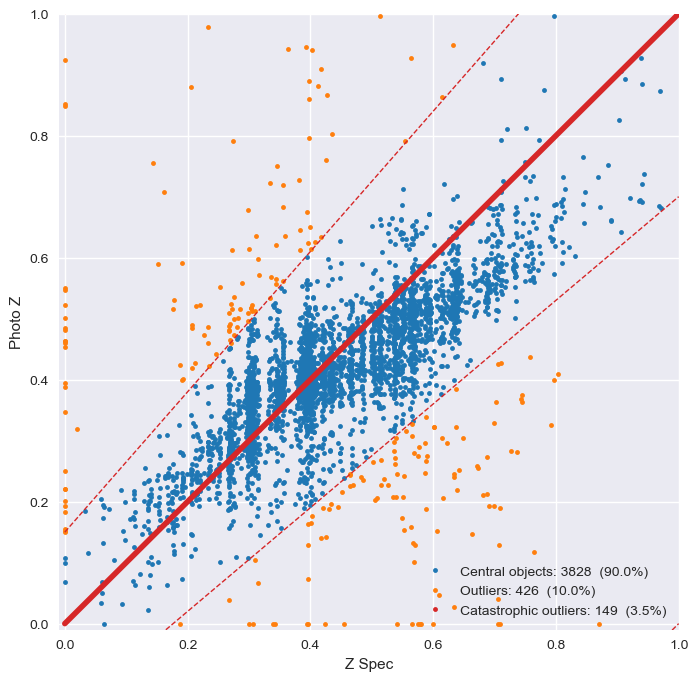

In [119]:
zspec_zphot(gamelp_out_ap1_2D['ZSPEC'][nsflag_zero],gamelp_out_ap1_2D['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2D['ZSPEC'][nsflag_zero],gamelp_out_ap1_2D['Z_BEST'][nsflag_zero],macs0416)

# match7_ap1_2E
## NEW CATALOG: ZP_u fixed, Context fixed, Error on mags
## CONTEXT -1, ZFIX NO, AUTO_ADAPT YES

In [122]:
gamelp_out_ap1_2E = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2E/match7_ap1_2E.out",sep='\s+',skiprows=82,header=None)
gamelp_out_ap1_2E.columns = header_lp

|mean(Delta z)| = 0.0687
std(Delta z)    = 0.1867
sigma_NMAD      = 0.0456
sigma_68        = 0.0498
eta             = 7.38 %
Galaxies having zphot in the cluster interval:  5941
Purity: Zphot with Zspec inside the cluster interval 635    (49.38)
Impurity: Zphot with Zspec otside the cluster interval 649    (50.47)


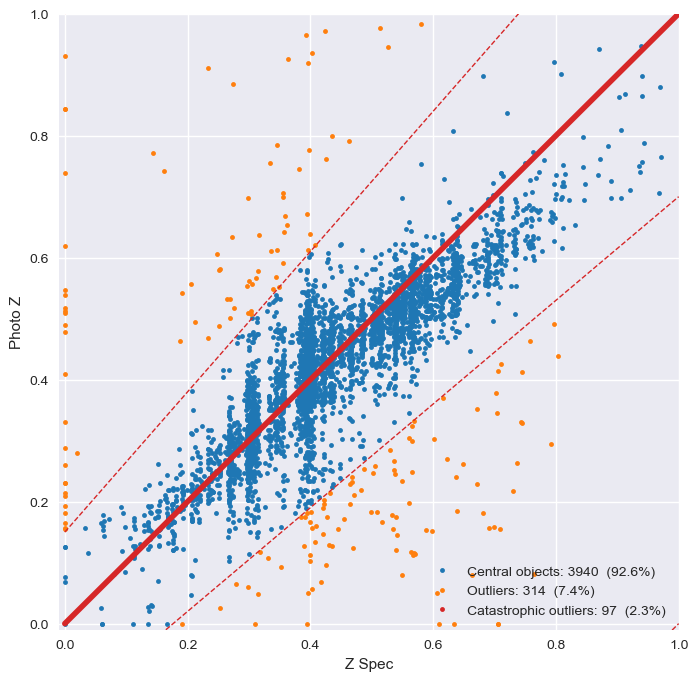

In [123]:
zspec_zphot(gamelp_out_ap1_2E['ZSPEC'][nsflag_zero],gamelp_out_ap1_2E['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2E['ZSPEC'][nsflag_zero],gamelp_out_ap1_2E['Z_BEST'][nsflag_zero],macs0416)

In [126]:
# OLD WAY TO COMPUTE THE PURITY OF THE PHOTOZ 
# How many galaxies have a redshift int the inverval 0.34<z_phot<0.47
gamelp_ap1_2E_cluster = gamelp_out_ap1_2E[zphot_cluster_ap1_2E]
print('Galaxies having zphot in the cluster interval: ',len(gamelp_ap1_2E_cluster))

# How many of these 5102 zphot do have zspec? ---> MATCH match7[zphot_cluster] WITH spectro4u ===> zspec_match_zphotcluster: 759 galaxies!!!
zspec_match_zphotcluster_ap1_2E = gamelp_ap1_2E_cluster[gamelp_ap1_2E_cluster['IDENT'].isin(game['ID_game'][game_zspec])]

zspec_match_zphotcluster_ap1_2E.reset_index(drop=True, inplace=True)
zspec_match_zphotcluster_ap1_2E.describe()

# from these zspec_match_zphotcluster, how many zspec inside the 0.38<z_spec<0.41 inverval and how many outside? ---> QUANTIFY!!!
zphot_with_zspec_inside_ap1_2E  = (zspec_match_zphotcluster_ap1_2E['ZSPEC']>0.382) & (zspec_match_zphotcluster_ap1_2E['ZSPEC']<0.41)
zphot_with_zspec_outside_ap1_2E = (zspec_match_zphotcluster_ap1_2E['ZSPEC']<0.382) | (zspec_match_zphotcluster_ap1_2E['ZSPEC']>0.41)

print('Purezza: Zphot con Zspec inside the cluster interval',zphot_with_zspec_inside_ap1_2E.sum(), ' Percentuale %.2f'%(zphot_with_zspec_inside_ap1_2E.sum()*100/len(zspec_match_zphotcluster_ap1_2E)))
print('Impurezza: Zphot con Zspec otside the cluster interval',zphot_with_zspec_outside_ap1_2E.sum(), 'Percentuale %.2f'%(zphot_with_zspec_outside_ap1_2E.sum()*100/len(zspec_match_zphotcluster_ap1_2E)))

Galaxies having zphot in the cluster interval:  6882
Purezza: Zphot con Zspec inside the cluster interval 658  Percentuale 48.78
Impurezza: Zphot con Zspec otside the cluster interval 689 Percentuale 51.07


# COSMOS PHOTOZ

|mean(Delta z)| = 0.3188
std(Delta z)    = 1.0919
sigma_NMAD      = 0.0227
sigma_68        = 0.0430
eta             = 19.25 %
Galaxies having zphot in the cluster interval:  3204
Purity: Zphot with Zspec inside the cluster interval 475    (14.83)
Impurity: Zphot with Zspec otside the cluster interval 2727    (85.11)


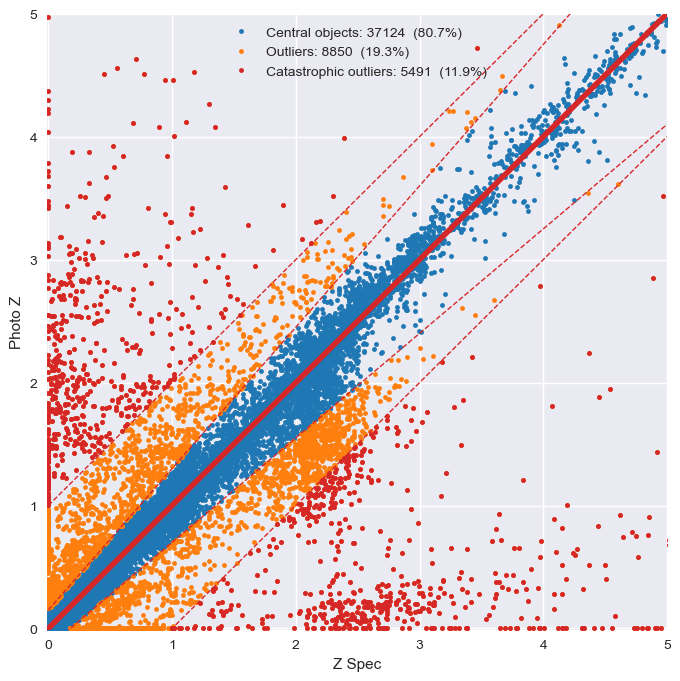

In [136]:
cosmos = pd.read_csv('/Users/nestrada/Downloads/cosmos_zspec_zphot.cat',sep=',')
good_cosmos   = (cosmos['z_spec']>= 0) & (cosmos['z_spec']< 10) & (cosmos['PHOTOZ']>=0) & (cosmos['PHOTOZ']< 10)
zspec_zphot(cosmos['z_spec'][good_cosmos],cosmos['PHOTOZ'][good_cosmos],(0,5))
purezza(cosmos['z_spec'][good_cosmos],cosmos['PHOTOZ'][good_cosmos],macs0416)


# match7_ap1_2E_HD
## NEW CATALOG: ZP_u fixed, Context fixed, Error on mags
## CONTEXT -1, ZFIX NO, AUTO_ADAPT YES
## IDEM to 2E but with a narrow grid in redshift!

In [138]:
gamelp_out_ap1_2E_HD = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2E_HD/match7_ap1_2E_HD.out",sep='\s+',skiprows=82,header=None)
gamelp_out_ap1_2E_HD.columns = header_lp

|mean(Delta z)| = 0.0692
std(Delta z)    = 0.1871
sigma_NMAD      = 0.0477
sigma_68        = 0.0501
eta             = 7.29 %
Galaxies having zphot in the cluster interval:  6051
Purity: Zphot with Zspec inside the cluster interval 639    (48.97)
Impurity: Zphot with Zspec otside the cluster interval 664    (50.88)


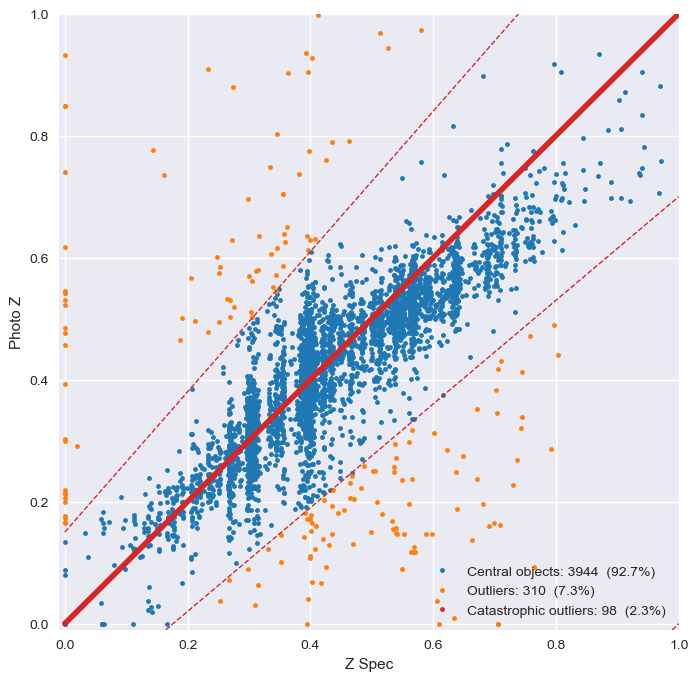

In [139]:
zspec_zphot(gamelp_out_ap1_2E_HD['ZSPEC'][nsflag_zero],gamelp_out_ap1_2E_HD['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2E_HD['ZSPEC'][nsflag_zero],gamelp_out_ap1_2E_HD['Z_BEST'][nsflag_zero],macs0416)

# match7_ap1_2F
## SAME AS 2E (CONTEXT -1, ZFIX NO, AUTO_ADAPT YES)
## DIFFERENT LIBRARIES: BC03 EM_LINES NO

In [146]:
gamelp_out_ap1_2F = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2F/match7_ap1_2F.out",sep='\s+',skiprows=82,header=None)
gamelp_out_ap1_2F.columns = header_lp

|mean(Delta z)| = 0.0687
std(Delta z)    = 0.1867
sigma_NMAD      = 0.0456
sigma_68        = 0.0498
eta             = 7.38 %
Galaxies having zphot in the cluster interval:  5941
Purity: Zphot with Zspec inside the cluster interval 635    (49.38)
Impurity: Zphot with Zspec otside the cluster interval 649    (50.47)


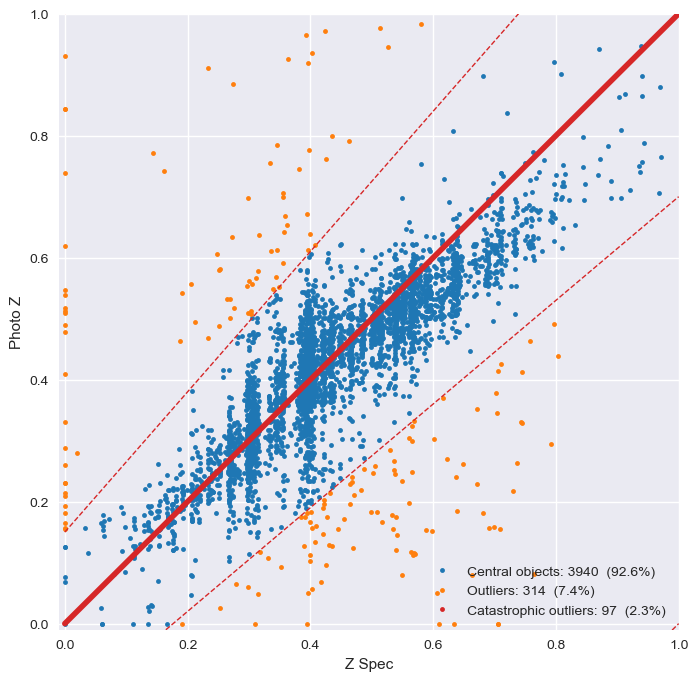

In [147]:
zspec_zphot(gamelp_out_ap1_2F['ZSPEC'][nsflag_zero],gamelp_out_ap1_2F['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2F['ZSPEC'][nsflag_zero],gamelp_out_ap1_2F['Z_BEST'][nsflag_zero],macs0416)

# match7_ap1_2G
## SAME AS 2E (CONTEXT -1, ZFIX NO, AUTO_ADAPT YES)
## DIFFERENT LIBRARIES: BC03 EM_LINES YES

In [149]:
gamelp_out_ap1_2G = pd.read_csv("/Users/nestrada/MEGA/MEGAsync/PhD/MEGA_GAME/photoz_SED/match7_ap1_2G/match7_ap1_2G.out",sep='\s+',skiprows=82,header=None)
gamelp_out_ap1_2G.columns = header_lp

|mean(Delta z)| = 0.0687
std(Delta z)    = 0.1867
sigma_NMAD      = 0.0456
sigma_68        = 0.0498
eta             = 7.38 %
Galaxies having zphot in the cluster interval:  5941
Purity: Zphot with Zspec inside the cluster interval 635    (49.38)
Impurity: Zphot with Zspec otside the cluster interval 649    (50.47)


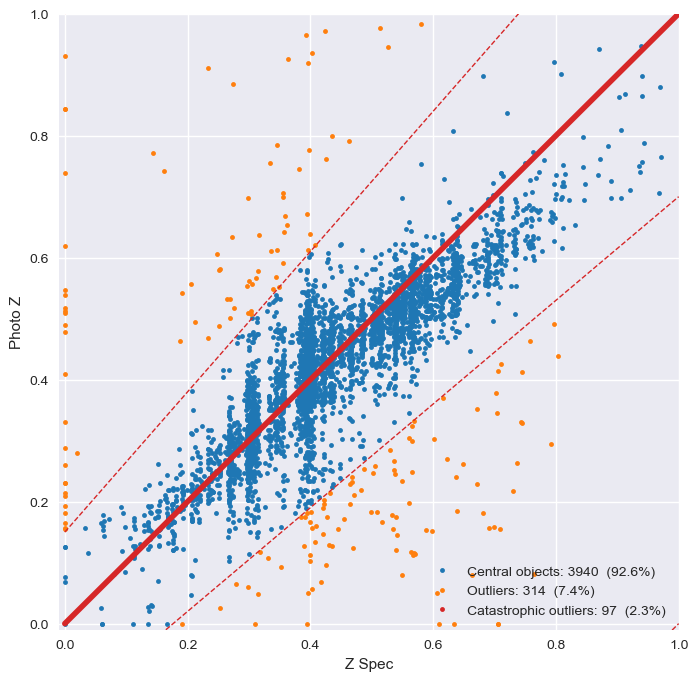

In [150]:
zspec_zphot(gamelp_out_ap1_2G['ZSPEC'][nsflag_zero],gamelp_out_ap1_2G['Z_BEST'][nsflag_zero],(0,1))
purezza(gamelp_out_ap1_2G['ZSPEC'][nsflag_zero],gamelp_out_ap1_2G['Z_BEST'][nsflag_zero],macs0416)